In [13]:
import random
import numpy as np
import csv
from sklearn import svm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from sklearn import preprocessing
from sklearn.decomposition import TruncatedSVD
import nltk

In [14]:
nltk.download('punkt') # for tokenization
nltk.download('stopwords')
stpwds = set(nltk.corpus.stopwords.words("english"))
stemmer = nltk.stem.PorterStemmer()

[nltk_data] Downloading package punkt to /home/caykroyd/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/caykroyd/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [15]:
with open("testing_set.txt", "r") as f:
    reader = csv.reader(f)
    testing_set  = list(reader)

In [16]:
testing_set = [element[0].split(" ") for element in testing_set]

In [17]:
with open("training_set.txt", "r") as f:
    reader = csv.reader(f)
    training_set  = list(reader)

training_set = [element[0].split(" ") for element in training_set]

In [18]:
with open("node_information.csv", "r") as f:
    reader = csv.reader(f)
    node_info  = list(reader)

In [19]:
IDs = [element[0] for element in node_info]

In [20]:
# compute TFIDF vector of each paper
corpus = [element[5] for element in node_info]
vectorizer = TfidfVectorizer(stop_words="english")
# each row is a node in the order of node_info
features_TFIDF = vectorizer.fit_transform(corpus)

In [21]:
from sklearn.metrics.pairwise import cosine_similarity
c = cosine_similarity(features_TFIDF['1001'], features_TFIDF[1:2])
c

array([[0.01249384]])

In [59]:
to_keep = random.sample(range(len(training_set)), k=int(round(len(training_set)*0.5)))
training_set_reduced = [training_set[i] for i in to_keep]

In [60]:
#using training set as testing_set
to_keep = random.sample(range(len(training_set)), k=int(round(len(training_set)*0.05)))
testing_set_with_answers = [training_set[i] for i in to_keep]


In [61]:
import math

c_similarity = []

# temporal distance between the papers
temp_diff = []

jaccard = []

# number of overlapping words in title
overlap_title = []

# number of common authors
comm_auth = []

for (id1, id2, expected) in training_set_reduced:
    temp_diff.append(math.atan(int(node_info[IDs_dic[id1]][1]) - int(node_info[IDs_dic[id2]][1])))
    c_similarity.append(cosine_similarity(features_TFIDF[IDs_dic[id1]], features_TFIDF[IDs_dic[id2]])[0][0])
    set_id1 = set(features_TFIDF[IDs_dic[id1]].nonzero()[1])
    set_id2 = set(features_TFIDF[IDs_dic[id2]].nonzero()[1])
    jaccard.append(len(set_id1 & set_id2) / len(set_id1 | set_id2))
    
    # convert to lowercase and tokenize
    source_title = node_info[IDs_dic[id1]][2].lower().split(" ")
    target_title = node_info[IDs_dic[id2]][2].lower().split(" ")

    # remove stopwords
    source_title = [token for token in source_title if token not in stpwds]
    source_title = [stemmer.stem(token) for token in source_title]
    
    target_title = [token for token in target_title if token not in stpwds]
    target_title = [stemmer.stem(token) for token in target_title]
    
    source_auth = node_info[IDs_dic[id1]][3].split(",")
    target_auth = node_info[IDs_dic[id2]][3].split(",")
    
    overlap_title.append(len(set(source_title).intersection(set(target_title))))
    comm_auth.append(len(set(source_auth).intersection(set(target_auth))))

temp_diff

[0.7853981633974483,
 1.1071487177940904,
 -1.3258176636680326,
 0.7853981633974483,
 1.2490457723982544,
 -1.4711276743037347,
 1.3258176636680326,
 1.1071487177940904,
 -1.1071487177940904,
 0.0,
 0.7853981633974483,
 1.2490457723982544,
 0.7853981633974483,
 1.2490457723982544,
 1.3258176636680326,
 1.2490457723982544,
 1.3258176636680326,
 1.4056476493802699,
 1.460139105621001,
 1.3258176636680326,
 1.4056476493802699,
 1.2490457723982544,
 1.446441332248135,
 1.3258176636680326,
 -1.2490457723982544,
 1.1071487177940904,
 0.7853981633974483,
 0.7853981633974483,
 1.4711276743037347,
 0.0,
 1.2490457723982544,
 -1.1071487177940904,
 1.2490457723982544,
 0.7853981633974483,
 -1.3258176636680326,
 1.1071487177940904,
 -1.4056476493802699,
 0.0,
 1.1071487177940904,
 1.460139105621001,
 -1.1071487177940904,
 -0.7853981633974483,
 1.4056476493802699,
 0.0,
 1.1071487177940904,
 1.2490457723982544,
 0.0,
 1.1071487177940904,
 0.7853981633974483,
 1.3258176636680326,
 0.7853981633974483

In [62]:
training_features = np.array([c_similarity, temp_diff, jaccard, overlap_title, comm_auth]).T

training_features = preprocessing.scale(training_features)

In [63]:
# convert labels into integers then into column array
labels = [int(element[2]) for element in training_set_reduced]
labels = list(labels)
labels_array = np.array(labels)

# initialize basic SVM
classifier = svm.LinearSVC()

# train
classifier.fit(training_features, labels_array)

/home/caykroyd/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [64]:
c_similarity_test = []

temp_diff_test = []

jaccard_test = []

# number of overlapping words in title
overlap_title_test = []

# number of common authors
comm_auth_test = []

for (id1, id2, expected) in testing_set_with_answers:
    temp_diff_test.append(math.atan(int(node_info[IDs_dic[id1]][1]) - int(node_info[IDs_dic[id2]][1])))
    c_similarity_test.append(cosine_similarity(features_TFIDF[IDs_dic[id1]], features_TFIDF[IDs_dic[id2]])[0][0])
    set_id1 = set(features_TFIDF[IDs_dic[id1]].nonzero()[1])
    set_id2 = set(features_TFIDF[IDs_dic[id2]].nonzero()[1])
    jaccard_test.append(len(set_id1 & set_id2) / len(set_id1 | set_id2))
        
    # convert to lowercase and tokenize
    source_title = node_info[IDs_dic[id1]][2].lower().split(" ")
    target_title = node_info[IDs_dic[id2]][2].lower().split(" ")

    # remove stopwords
    source_title = [token for token in source_title if token not in stpwds]
    source_title = [stemmer.stem(token) for token in source_title]
    
    target_title = [token for token in target_title if token not in stpwds]
    target_title = [stemmer.stem(token) for token in target_title]
    
    source_auth = node_info[IDs_dic[id1]][3].split(",")
    target_auth = node_info[IDs_dic[id2]][3].split(",")
    
    overlap_title_test.append(len(set(source_title).intersection(set(target_title))))
    comm_auth_test.append(len(set(source_auth).intersection(set(target_auth))))
   
c_similarity_test

[0.0,
 0.17791907442515056,
 0.0,
 0.06654206270684862,
 0.06957060198231693,
 0.018581503563053013,
 0.16712793282180374,
 0.006259500289832516,
 0.07161185406753498,
 0.1489896234552735,
 0.0,
 0.0,
 0.006152878983422748,
 0.029091050837229137,
 0.3799046872329499,
 0.024881284373612284,
 0.15162526699970133,
 0.021667354010425743,
 0.0,
 0.03384663761688989,
 0.0057119705344133905,
 0.5006510625842756,
 0.11332948173514942,
 0.04352578894421992,
 0.19464766206538509,
 0.11044935092227284,
 0.1062592133300713,
 0.14777445853746124,
 0.0,
 0.5358373904565017,
 0.01734443971143475,
 0.0069512474255083116,
 0.005930511624250733,
 0.13181429375357587,
 0.05257899656398094,
 0.28400282006433963,
 0.026907837146875096,
 0.05867723722877782,
 0.05184405664802654,
 0.03608069566942758,
 0.032081794420935394,
 0.0032682108527951215,
 0.25411236570177015,
 0.07020041591187925,
 0.030792919427375345,
 0.09812264614216148,
 0.048889935608649286,
 0.10064169248901118,
 0.17026648049303306,
 0.028

In [57]:
# convert list of lists into array
# documents as rows, unique words as columns (i.e., example as rows, features as columns)
testing_features = np.array([c_similarity_test, temp_diff_test, jaccard_test, overlap_title_test, comm_auth_test]).T

# scale
testing_features = preprocessing.scale(testing_features)

# issue predictions
predictions_SVM = list(classifier.predict(testing_features))

In [58]:
tp = 0 #true positive
fp = 0 #false positive
fn = 0 #false negative
    
for i in range(len(testing_set_with_answers)):
    if predictions_SVM[i] == 1 and int(testing_set_with_answers[i][2]) == 1:
        tp += 1
    elif predictions_SVM[i] == 1 and int(testing_set_with_answers[i][2]) == 0:
        fp += 1
    elif int(testing_set_with_answers[i][2]) == 1:
        fn += 1
    
p = tp/(tp+fp) #precision
r = tp/(tp+fn) #recall
f = (2*p*r)/(p+r)
print(f)

0.8547410894418292


In [35]:
# Fit LSA. Use algorithm = "randomized" for large datasets
components = 3
lsa = TruncatedSVD(components, algorithm = 'randomized')
dtm_lsa = lsa.fit_transform(features_TFIDF)
dtm_lsa = preprocessing.Normalizer(copy=False).fit_transform(dtm_lsa)

In [221]:
xs = [w[0] for w in dtm_lsa]
ys = [w[1] for w in dtm_lsa]
zs = [w[2] for w in dtm_lsa]
#qs = [w[3] for w in dtm_lsa]

Populating the interactive namespace from numpy and matplotlib


/home/user/anaconda3/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['f', 'dist']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


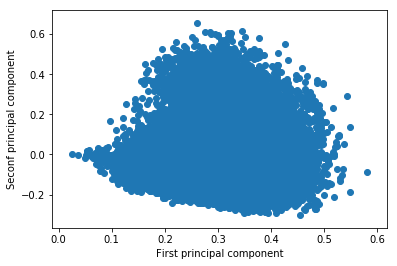

In [191]:
%pylab inline
import matplotlib.pyplot as plt
figure()
plt.scatter(xs, ys)
xlabel('First principal component')
ylabel('Seconf principal component')
show()

In [25]:
radius = np.arange(0.05, 1, 0.05)
IDs_dic = dict(zip(IDs,range(len(IDs))))
cosine_similarity(features_TFIDF[IDs_dic['1001']], features_TFIDF[IDs_dic['1002']])

array([[0.01292476]])

In [55]:
F1 = []

for epsilon in radius:
    tp = 0 #true positive
    fp = 0 #false positive
    fn = 0 #false negative

    for (id1, id2, expected) in training_set:
        predicted = cosine_similarity(features_TFIDF[IDs_dic[id1]], features_TFIDF[IDs_dic[id2]])[0][0] >= epsilon and int(node_info[IDs_dic[id1]][1]) >= int(node_info[IDs_dic[id2]][1])
        if (predicted == True and expected == '1'):
            tp += 1
        elif (predicted == True and expected == '0'):
            fp += 1
        elif (expected == '1'):
            fn += 1

    p = tp/(tp+fp) #precision
    r = tp/(tp+fn) #recall
    f = (2*p*r)/(p+r)
    
    print(tp,fp,fn,p,r,f)

    F1.append(f)

F1

257276 22168 77854 0.9206710467929173 0.7676901500910095 0.8372498673878166


KeyboardInterrupt: 

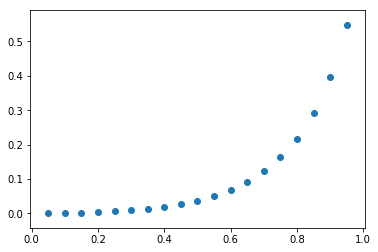

[0.000445648686227673,
 0.0010015883175686889,
 0.0018483305972528967,
 0.0031842643291894812,
 0.0053814276542345175,
 0.008392466459073704,
 0.012846333895814055,
 0.018750919440075137,
 0.026385047729503078,
 0.03713421782048052,
 0.05081545064377682,
 0.06893899759338705,
 0.09196015246279211,
 0.12261968932229138,
 0.16337538426932594,
 0.2175609367250053,
 0.29133009788599157,
 0.39524096027572275,
 0.5476837060702876]

In [232]:
figure()
plt.scatter(radius, F1)
show()
F1

In [125]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn.neighbors import KNeighborsClassifier

X_train_raw = corpus
y_train_labels = raw_text_dataset[1] 
X_test_raw = raw_text_dataset[2]
y_test_labels = raw_text_dataset[3]

# The Reuters dataset consists of ~100 categories. However, we are going to
# simplify this to a binary classification problem. The 'positive class' will
# be the articles related to "acquisitions" (or "acq" in the dataset). All
# other articles will be negative.
y_train = ["acq" in y for y in y_train_labels]
y_test = ["acq" in y for y in y_test_labels]


vectorizer = TfidfVectorizer(max_df=0.5, max_features=10000,
                             min_df=2, stop_words='english',
                             use_idf=True)

# Build the tfidf vectorizer from the training data ("fit"), and apply it 
# ("transform").
X_train_tfidf = vectorizer.fit_transform(X_train_raw)

print("  Actual number of tfidf features: %d" % X_train_tfidf.get_shape()[1])

print("\nPerforming dimensionality reduction using LSA")
t0 = time.time()

# Project the tfidf vectors onto the first N principal components.
# Though this is significantly fewer features than the original tfidf vector,
# they are stronger features, and the accuracy is higher.
svd = TruncatedSVD(100)
lsa = make_pipeline(svd, Normalizer(copy=False))

# Run SVD on the training data, then project the training data.
X_train_lsa = lsa.fit_transform(X_train_tfidf)

print("  done in %.3fsec" % (time.time() - t0))

explained_variance = svd.explained_variance_ratio_.sum()
print("  Explained variance of the SVD step: {}%".format(int(explained_variance * 100)))


# Now apply the transformations to the test data as well.
X_test_tfidf = vectorizer.transform(X_test_raw)
X_test_lsa = lsa.transform(X_test_tfidf)


###############################################################################
#  Run classification of the test articles
###############################################################################

print("\nClassifying tfidf vectors...")

# Time this step.
t0 = time.time()

# Build a k-NN classifier. Use k = 5 (majority wins), the cosine distance, 
# and brute-force calculation of distances.
knn_tfidf = KNeighborsClassifier(n_neighbors=5, algorithm='brute', metric='cosine')
knn_tfidf.fit(X_train_tfidf, y_train)

# Classify the test vectors.
p = knn_tfidf.predict(X_test_tfidf)

# Measure accuracy
numRight = 0;
for i in range(0,len(p)):
    if p[i] == y_test[i]:
        numRight += 1

print("  (%d / %d) correct - %.2f%%" % (numRight, len(y_test), float(numRight) / float(len(y_test)) * 100.0))

# Calculate the elapsed time (in seconds)
elapsed = (time.time() - t0)
print("  done in %.3fsec" % elapsed)


print("\nClassifying LSA vectors...")

# Time this step.
t0 = time.time()

# Build a k-NN classifier. Use k = 5 (majority wins), the cosine distance, 
# and brute-force calculation of distances.
knn_lsa = KNeighborsClassifier(n_neighbors=5, algorithm='brute', metric='cosine')
knn_lsa.fit(X_train_lsa, y_train)

# Classify the test vectors.
p = knn_lsa.predict(X_test_lsa)

# Measure accuracy
numRight = 0;
for i in range(0,len(p)):
    if p[i] == y_test[i]:
        numRight += 1

print("  (%d / %d) correct - %.2f%%" % (numRight, len(y_test), float(numRight) / float(len(y_test)) * 100.0))

# Calculate the elapsed time (in seconds)
elapsed = (time.time() - t0)    
print("    done in %.3fsec" % elapsed)